<a href="https://colab.research.google.com/github/emmermarcell/DeepLProject/blob/main/data_augmentation_under_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 07
 Draw by hand a few numbers. Augment this initial data, train a convolutional network and test it on the mnist dataset. Reach at least 50% success rate

In [ ]:
import os
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.cluster import KMeans
from skimage import measure
import matplotlib as mpl
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score
from keras import models, regularizers
import seaborn as sns

In [ ]:
# Check if we are using GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  device_name = '/device:CPU:0'
  print('GPU device not found, using CPU instead')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
path = r'/content/drive/MyDrive/ai-in-data-science/class07/'
os.chdir(path)
os.getcwd()

'/content/drive/MyDrive/ai-in-data-science/class07'

In [ ]:
def image_plotter(img_file_path: str):
  """
  Plot the image file.
  Args:
    img_file_path: String to the file path of the image
  """
  img = mpimg.imread(img_file_path)
  plt.imshow(img), plt.xticks([]), plt.yticks([])
  plt.show()

Load in the hand written images

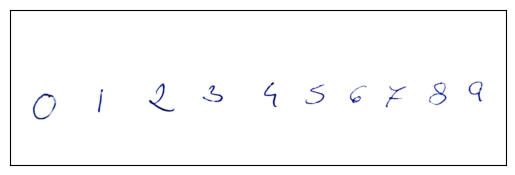

In [ ]:
image_plotter('mnist-image.jpg')

In [ ]:
number_pics_dir = os.path.join(os.getcwd(), 'number-pictures')
os.makedirs(number_pics_dir, exist_ok = True)

In [ ]:
def rect1_contains_rect2(rect1: measure._regionprops.RegionProperties, rect2: measure._regionprops.RegionProperties) -> bool:
  X_1, Y_1, X_2, Y_2 = rect1.bbox
  x_1, y_1, x_2, y_2 = rect2.bbox

  if x_1 >= X_1 and x_2 <= X_2 and y_1 >= Y_1 and y_2 <= Y_2:
    return True
  else:
    return False

Segment the images and convert them into 28x28 pixel .jpg files

In [ ]:
def image_segmenter(img_file_path: str, starting_num=0, D=10):
    """
    Segment the image
    Args:
      img_file_path (str): String to the file path of the image
      starting_num (int): number to start the indexing the number .png files
      D (int): Number of segments
    Returns:
      input_images (dict): Dictionary where the keys are the .png file names vcontaining the numbers and the values are empty at this point
      number_of_images (int): the number of images on the input picture (we need this for naming the .png files of the single numbers)
    """
    img = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
    # Find rectangles
    sm_img = img[::D,::D,:]
    rgb = sm_img.reshape((-1,3))
    kmeans = KMeans(n_clusters=2, init='random', n_init=10, random_state=42).fit(rgb)
    # Real clustering using the centers from the decimated ones
    rgb = img.reshape((-1,3))
    kmeans = KMeans(n_clusters=2,init=kmeans.cluster_centers_, n_init=10, random_state=42).fit(rgb)
    pred = kmeans.predict(rgb)
    res = pred.reshape(img.shape[:2])
    regions = measure.label(res,connectivity=2,background=-10)
    patches = measure.regionprops(regions)
    # Filter the solutions to get the relevant ones only
    image_area = img.shape[0] * img.shape[1]
    proper_patches = []

    for idx in range(len(patches)):
        if patches[idx].area <= 0.0001 * image_area:
            continue
        if patches[idx].area > 0.5*image_area:
            continue

        x_1, y_1, x_2, y_2 = patches[idx].bbox
        height = x_2 - x_1
        width = y_2 - y_1
        aspect_ratio = width / height

        # Remove elements from the edges, most likely bad solutions
        if x_1/img.shape[0] < 1e-6:
            continue
        if y_1/img.shape[1] < 1e-6:
            continue
        if aspect_ratio < 0.2 or aspect_ratio > 2:
            continue
        proper_patches.append(patches[idx])

    # Some patches still remain that are the loops inside the numbers 0, 6, 8, 9
    # Remove the patches that are inside other patches
    proper_patches_copy = proper_patches.copy()
    for rect1, rect2 in itertools.combinations(proper_patches_copy, 2):
        if rect1_contains_rect2(rect1, rect2):
            proper_patches.remove(rect2)

    # Plot the image with the rectangles around the numbers
    fig, (ax1) = plt.subplots(1,figsize=(20,20))
    plt.xticks([]),plt.yticks([])
    ax1.imshow(res)

    for idx in range(len(proper_patches)):
        height = proper_patches[idx].bbox[2] - proper_patches[idx].bbox[0]
        width = proper_patches[idx].bbox[3] - proper_patches[idx].bbox[1]

        rectBorder = mpl.patches.Rectangle(\
                    (proper_patches[idx].bbox[1], proper_patches[idx].bbox[0]), width, height, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rectBorder)

    plt.show()

    # Store the filenames of the image numbers in a dictionary (label them later manually)
    input_images = {}

    # Plot the numbers (make the image into a square!)
    gimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    for idx in range(len(proper_patches)):
        x_1, y_1, x_2, y_2 = proper_patches[idx].bbox
        patch_img = gimg[x_1-10:x_2+10,y_1-10:y_2+10]

        height = x_2 - x_1
        width = y_2 - y_1
        aspect_ratio = width / height

        # Add border!
        if aspect_ratio >= 1:
            diff = width-height
            base = width//15
            patch_img = cv2.copyMakeBorder(patch_img, base+diff//2, base+diff//2,  base, base, cv2.BORDER_REPLICATE)
        else:
            diff = height - width
            base = height//15
            patch_img = cv2.copyMakeBorder(patch_img, base+diff//2, base+diff//2,  base, base, cv2.BORDER_REPLICATE)
        # Resize the image to MNIST size
        patch_img = cv2.resize(patch_img, (28,28), interpolation = cv2.INTER_AREA)

        fig, (ax1) = plt.subplots()
        plt.xticks([]),plt.yticks([])
        ax1.imshow(patch_img)
        plt.show()
        # Save the image
        img_file_name = number_pics_dir+'/number_img'+str(starting_num+idx+1)+'.png'
        print(img_file_name)
        cv2.imwrite(img_file_name,patch_img)
        # Store the image file name in a dictionary (labels come later)
        input_images[img_file_name] = ''

    number_of_images = len(proper_patches)
    return input_images, number_of_images

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


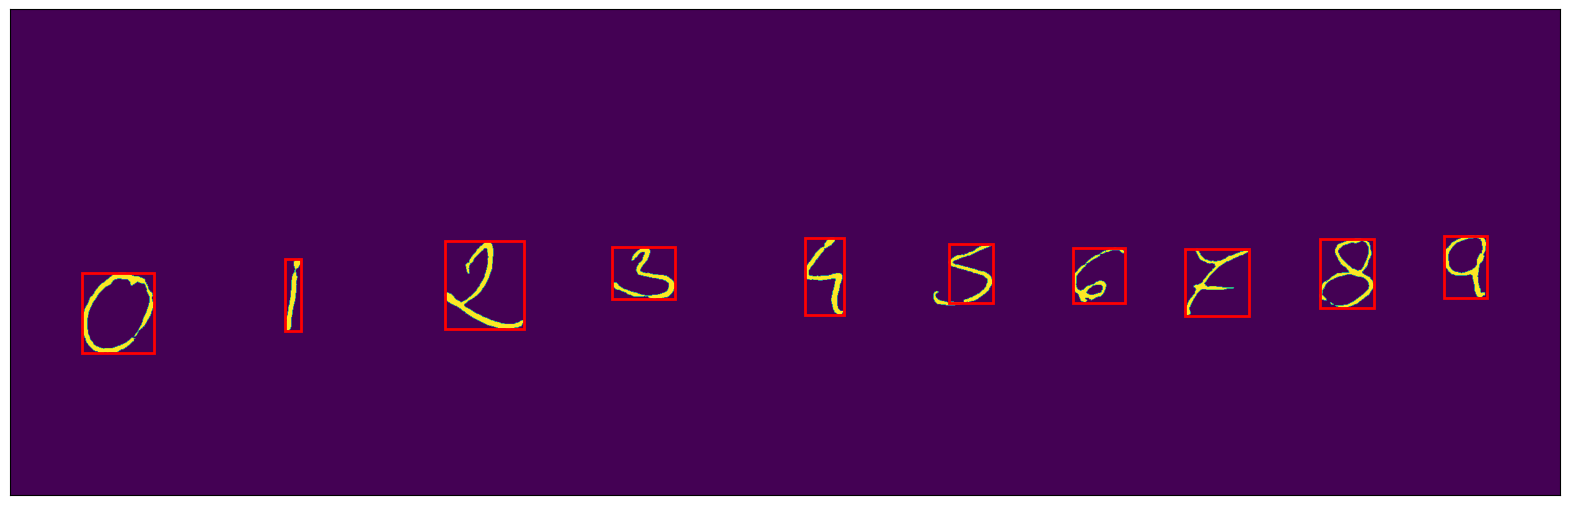

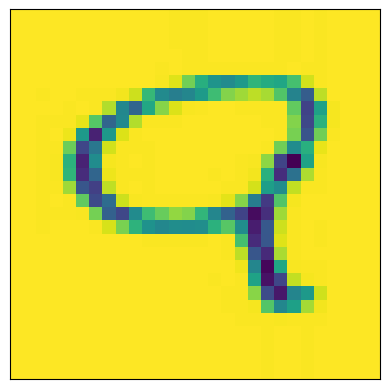

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img1.png


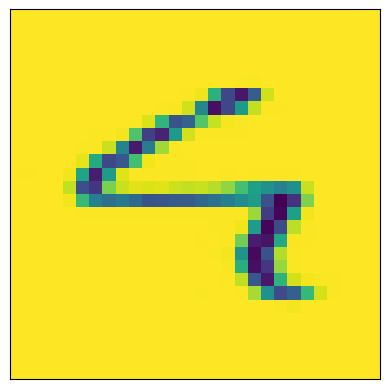

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img2.png


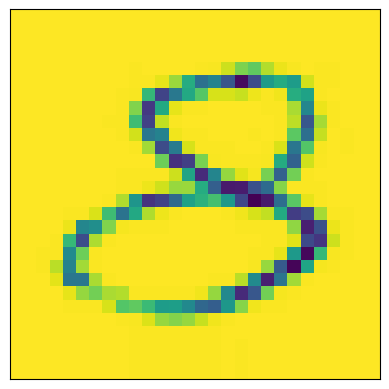

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img3.png


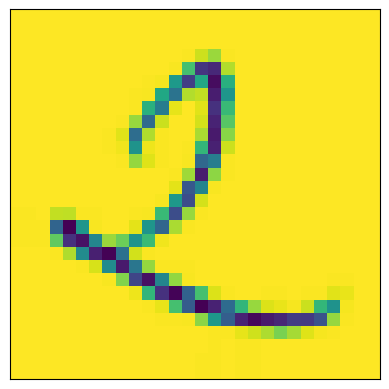

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img4.png


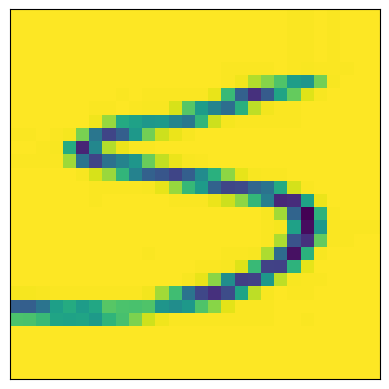

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img5.png


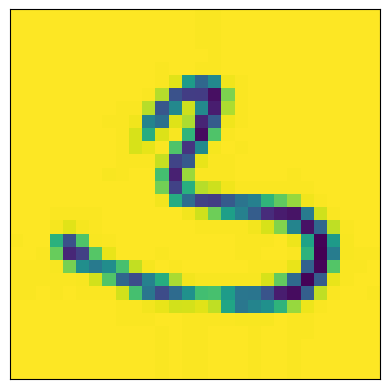

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img6.png


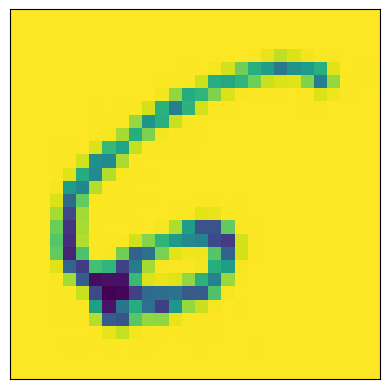

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img7.png


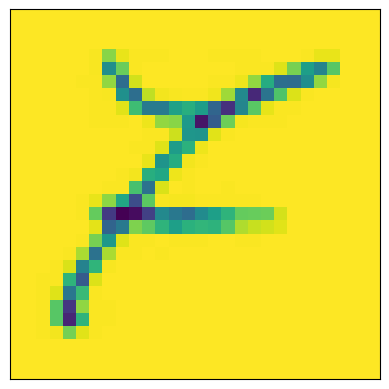

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img8.png


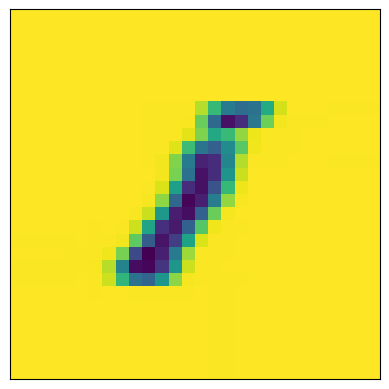

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img9.png


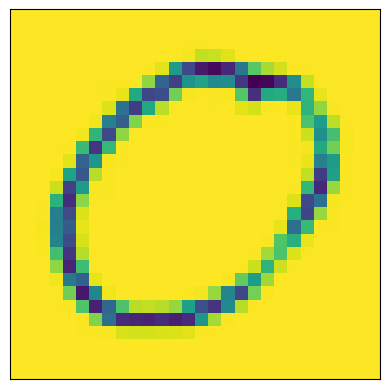

/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img10.png


In [ ]:
numbers = {}
number_counter = 0

input_images, number_of_images = image_segmenter('mnist-image.jpg', starting_num=number_counter, D=10)
numbers.update(input_images)
number_counter += number_of_images

In [ ]:
numbers[number_pics_dir+'/number_img1.png'] = 9
numbers[number_pics_dir+'/number_img2.png'] = 4
numbers[number_pics_dir+'/number_img3.png'] = 8
numbers[number_pics_dir+'/number_img4.png'] = 2
numbers[number_pics_dir+'/number_img5.png'] = 5
numbers[number_pics_dir+'/number_img6.png'] = 3
numbers[number_pics_dir+'/number_img7.png'] = 6
numbers[number_pics_dir+'/number_img8.png'] = 7
numbers[number_pics_dir+'/number_img9.png'] = 1
numbers[number_pics_dir+'/number_img10.png'] = 0

In [ ]:
numbers

{'/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img1.png': 9,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img2.png': 4,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img3.png': 8,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img4.png': 2,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img5.png': 5,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img6.png': 3,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img7.png': 6,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img8.png': 7,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img9.png': 1,
 '/content/drive/MyDrive/ai-in-data-science/class07/number-pictures/number_img10.png': 0}

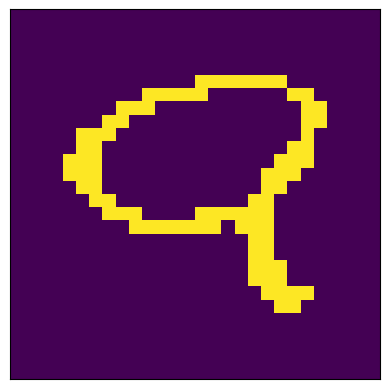

[9.]


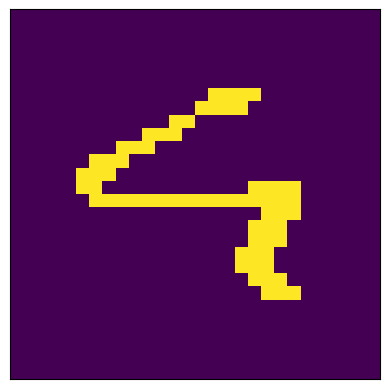

[4.]


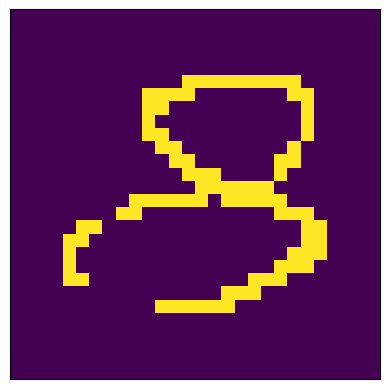

[8.]


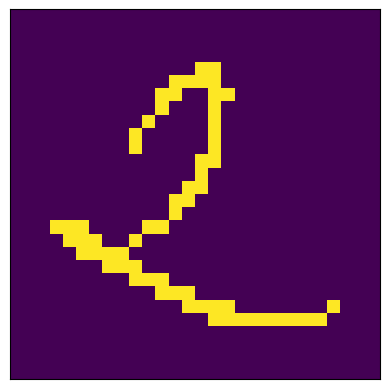

[2.]


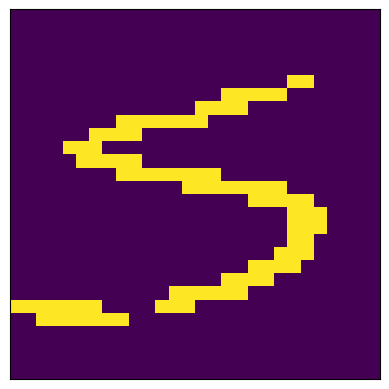

[5.]


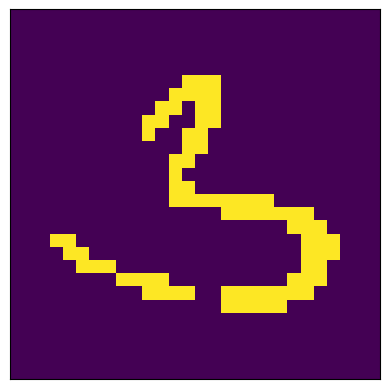

[3.]


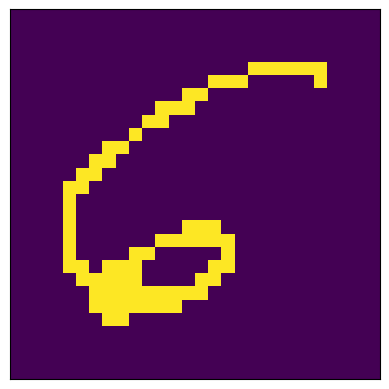

[6.]


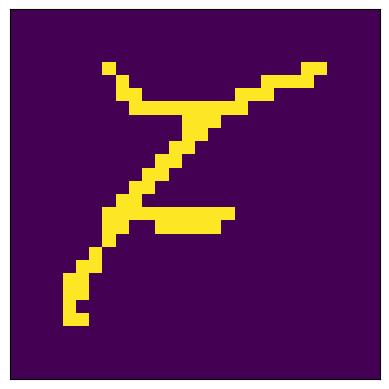

[7.]


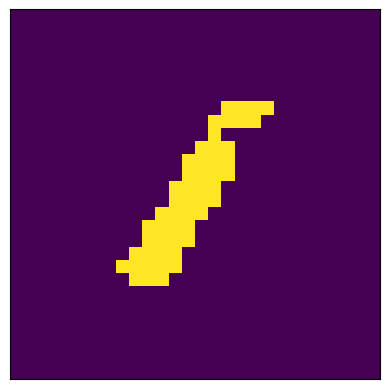

[1.]


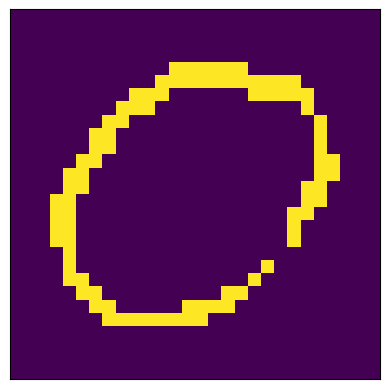

[0.]


In [ ]:
X_init = np.zeros(shape=(len(numbers) ,28, 28))
y_init = np.zeros(shape=(len(numbers),1))

idx = 0
for key, value in numbers.items():
  img = cv2.imread(key)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # Threshold the image
  thr,img = cv2.threshold(src=img, thresh=0, maxval=255, type=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  fig, (ax1) = plt.subplots()
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img)
  plt.show()

  X_init[idx] = img
  y_init[idx] = value
  print(y_init[idx])
  idx += 1

Augment the data!

In [ ]:
def image_augmenter(image: np.ndarray, sigma_rot: float, sigma_scale: float, sigma_aff: float) -> np.ndarray:
    """
    Randomly rotates and does an affine transformation on an image with a normal distribution.
    Inputs:
      image (np.ndarray): The original image we want to transform.
      sigma_rot (float): the standard deviation of the rotation angle in radian
      sigma_scale (float): the standard deviation of the scaling
      sigma_rot (float): the standard deviation of the affine transformation
    """
    rows, cols = image.shape

    # Rotation and scaling of the image
    rand_angle = np.random.normal(loc=0, scale=sigma_rot*360/np.pi)
    rand_scale = np.random.normal(loc=1, scale=sigma_scale)
    rot_mat = cv2.getRotationMatrix2D(center=(rows//2,cols//2), angle=rand_angle, scale=rand_scale)
    rotated_image = cv2.warpAffine( image, rot_mat, (cols, rows), borderValue=(0.,0.,0.) )

    # Affine transformation of the image
    pts1 = np.float32([[5, 5],
                   [20, 5],
                   [5, 20]])

    pts2 = np.random.normal(loc=pts1, scale=sigma_aff, size=pts1.shape)
    pts2 = pts2.astype(np.float32)
    affine_mat = cv2.getAffineTransform(pts1, pts2)
    transformed_image = cv2.warpAffine(rotated_image, affine_mat, (cols, rows), borderValue=(0.,0.,0.))

    # Use convolution to sharpen the image
    conv_kernel = np.array([[0,-.5,0],[-.5,3,-.5],[0,-.5,0]])
    convolved_image = np.clip(cv2.filter2D(transformed_image, -1, conv_kernel), 0,1)

    # Clip the values between 0 and 1
    output_image = np.clip(convolved_image,0.0,1.0)

    return output_image

In [ ]:
# Let's create 1000 images for each of the 10 number class based on one picture each
def generate_labels(image: np.ndarray, num_img: int, data=[], y_hat=[], label=0, sigma_rot=.1, sigma_scale=.3, sigma_aff=2.):
    for i in range(num_img):
        new_image = image_augmenter(image=image, sigma_rot=sigma_rot, sigma_scale=sigma_scale,sigma_aff=sigma_aff)
        data.append(new_image)
    y_hat = [label] * len(data)
    return np.array(data), np.array(y_hat)

In [ ]:
X_gen = []
y_gen = []
for i in range(len(y_init)):
    X_gen_digit, y_gen_digit = [], []
    X_gen_digit, y_gen_digit = generate_labels(image=X_init[i], num_img=10000, data=X_gen_digit, y_hat=y_gen_digit, label=int(y_init[i]))
    X_gen.append(X_gen_digit)
    y_gen.append(y_gen_digit)

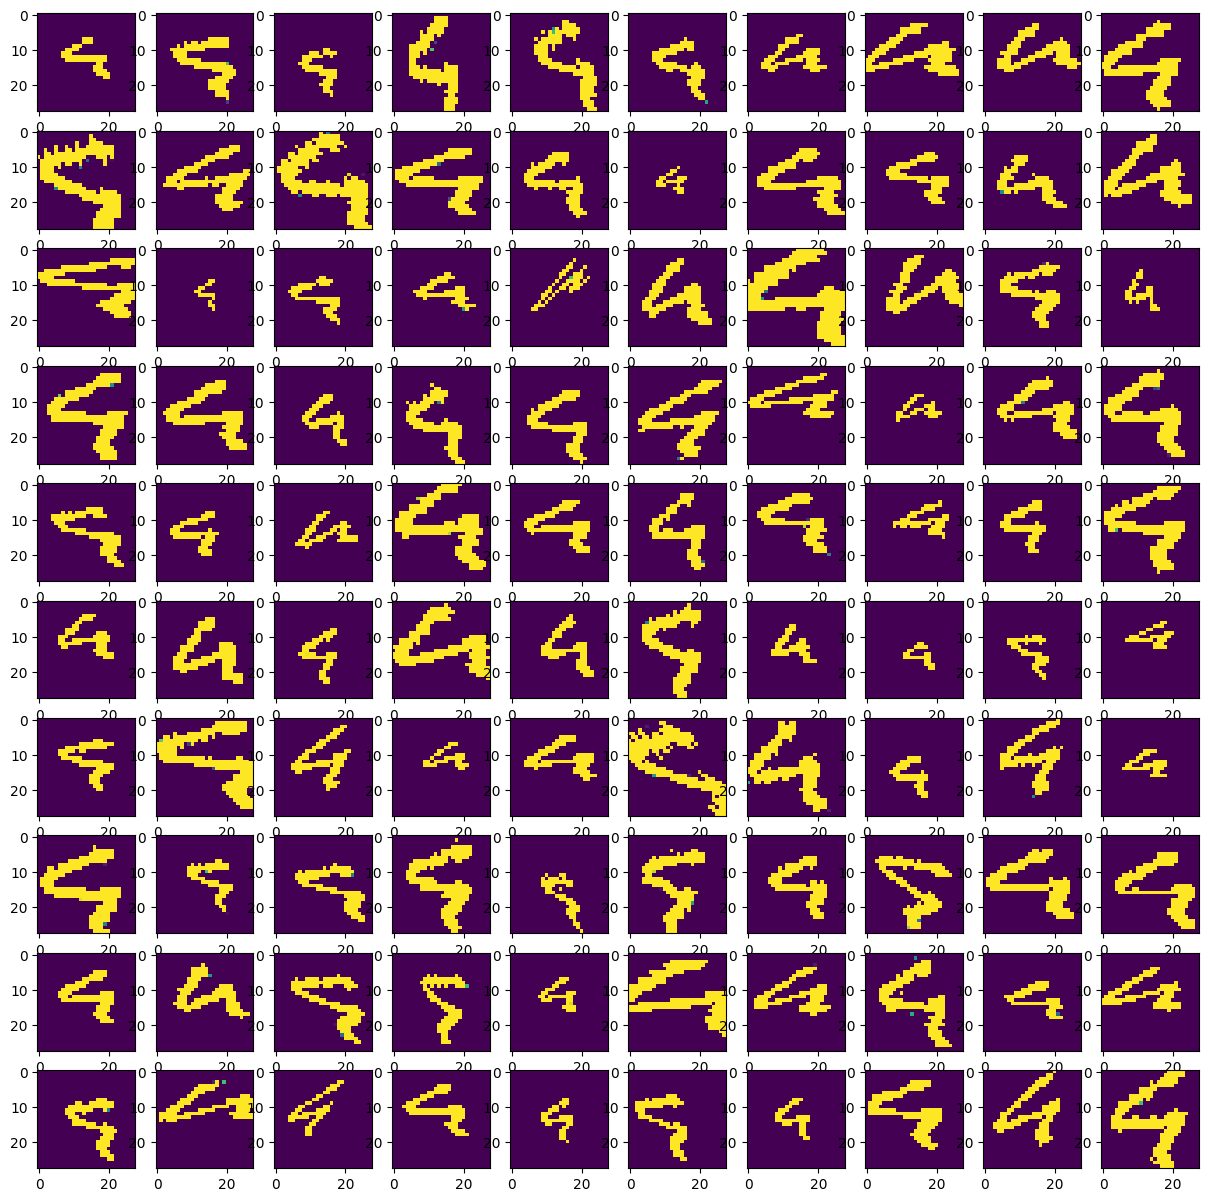

In [ ]:
plt.subplots(10,10,figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X_gen[1][i])

In [ ]:
# Create inputs for the NN
X_train = np.vstack((X_gen[i] for i in range(len(X_gen))))
y_train = np.hstack((y_gen[i] for i in range(len(y_gen)))).reshape(-1, 1)

<ipython-input-43-17aa5e9b375e>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_train = np.vstack((X_gen[i] for i in range(len(X_gen))))
<ipython-input-43-17aa5e9b375e>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_train = np.hstack((y_gen[i] for i in range(len(y_gen)))).reshape(-1, 1)


In [ ]:
# Create test set from the mnist images
(X_valid, y_valid), (X_test, y_test) = mnist.load_data()

# Min-max Scaling of the data
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_valid = (X_valid - X_valid.min()) / (X_valid.max() - X_valid.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

# One-hot encoding of the outputs
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [ ]:
# Create the model
classifier = Sequential()
classifier.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
classifier.add(MaxPooling2D(pool_size=(2, 2) ))
classifier.add(Dropout(0.25))
classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2) ))
classifier.add(Dropout(0.25))
classifier.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2) ))
classifier.add(Dropout(0.25))
classifier.add(Flatten())

classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(128, activation='relu',bias_regularizer=regularizers.l2(0.01),\
    kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
classifier.add(Dense(10, activation='softmax',bias_regularizer=regularizers.l2(0.01),\
    kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01)))
classifier.summary()

# Compiling the CNN
classifier.compile(optimizer = 'adam',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 128)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 12, 12, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 128)       147584    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 5, 5, 128)        

In [ ]:
patience=20
early_stopping=EarlyStopping(patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

In [ ]:
with tf.device(device_name):
    history = classifier.fit(X_train, y_train,
                            batch_size=40,
                            epochs=500,
                            validation_data=(X_valid, y_valid),
                            callbacks=[checkpointer, early_stopping])

Epoch 1/500
2495/2500 [============================>.] - ETA: 0s - loss: 0.7853 - accuracy: 0.9131
Epoch 1: val_loss improved from inf to 1.90820, saving model to weights.hdf5
2500/2500 [==============================] - 21s 8ms/step - loss: 0.7848 - accuracy: 0.9132 - val_loss: 1.9082 - val_accuracy: 0.4722
Epoch 2/500
  18/2500 [..............................] - ETA: 15s - loss: 0.5490 - accuracy: 0.9778

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2498/2500 [============================>.] - ETA: 0s - loss: 0.5270 - accuracy: 0.9789
Epoch 2: val_loss improved from 1.90820 to 1.86527, saving model to weights.hdf5
2500/2500 [==============================] - 20s 8ms/step - loss: 0.5270 - accuracy: 0.9790 - val_loss: 1.8653 - val_accuracy: 0.4955
Epoch 3/500
2498/2500 [============================>.] - ETA: 0s - loss: 0.4964 - accuracy: 0.9842
Epoch 3: val_loss did not improve from 1.86527
2500/2500 [==============================] - 24s 10ms/step - loss: 0.4963 - accuracy: 0.9842 - val_loss: 1.9368 - val_accuracy: 0.4689
Epoch 4/500
2499/2500 [============================>.] - ETA: 0s - loss: 0.4808 - accuracy: 0.9860
Epoch 4: val_loss did not improve from 1.86527
2500/2500 [==============================] - 19s 7ms/step - loss: 0.4808 - accuracy: 0.9860 - val_loss: 1.9123 - val_accuracy: 0.4603
Epoch 5/500
2499/2500 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.9878
Epoch 5: val_loss improved from 1.8652

In [ ]:
model = load_model('weights.hdf5')

preds = model.predict(X_test)
test_err = accuracy_score(tf.argmax(y_test, axis = 1),tf.argmax(preds, axis = 1))

# possible values of outcomes:
print('Accuracy of the best model is ', test_err)

313/313 [==============================] - 1s 2ms/step
Accuracy of the best model is  0.5048


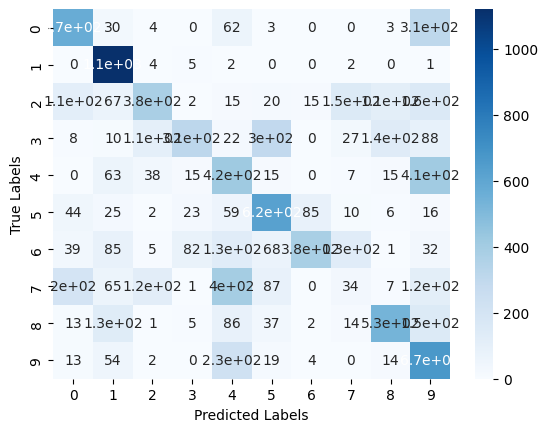

In [ ]:
confusion_matrix = tf.math.confusion_matrix(tf.argmax(y_test, axis = 1),tf.argmax(preds, axis = 1))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()